In [1]:
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
import pandas as pd
import os
from PIL import Image

import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception, VGG16, ResNet50, InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator


import numpy as np # linear algebra

from numpy.random import seed

Using TensorFlow backend.


In [2]:
K.clear_session()

In [3]:
SEED = 2
seed(SEED)
tf.set_random_seed(SEED)
%matplotlib inline

In [4]:
def basic_preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


In [5]:
#https://github.com/yu4u/cutout-random-erasing
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=True, ismixup=False):
    def eraser(input_img, ismixup=ismixup):
        if not ismixup:
            input_img = basic_preprocess_input(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        
        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [29]:

class MixupImageDataGenerator():
    def __init__(self, generator, dataframe, directory, target, batch_size, img_size, israndombox,
                 alpha=0.2, subset=None, scale='rgb',min_mixup=70, max_mixup=100):
        """Constructor for mixup image data generator.

        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.

        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha
        # First iterator yielding tuples of (x, y)
        self.erasor = get_random_eraser(ismixup=True)
        self.min_mixup = min_mixup
        self.max_mixup = max_mixup
        self.generator1 = generator.flow_from_dataframe(dataframe=dataframe, 
                                                        directory=directory,
                                                        x_col = 'img_file',
                                                        y_col = target,
                                                        target_size=(image_size, image_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        seed=3,
                                                        color_mode=scale,
                                                        shuffle=True)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_dataframe(dataframe=dataframe, 
                                                        directory=directory,
                                                        x_col = 'img_file',
                                                        y_col = target,
                                                        target_size=(image_size, image_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        seed=5,
                                                        color_mode=scale,
                                                        shuffle=True)


        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.

        Returns:
            int -- steps per epoch.
        """
        if (num_samples % batch_size) > 0:
            return (num_samples // batch_size) + 1
        else:
            return num_samples // batch_size

    def __next__(self):
        """Get next batch input/output pair.

        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0
        
        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()
        size = X1.shape[0]
        # random sample the lambda value from beta distribution.
        l = np.random.randint(self.min_mixup, self.max_mixup, size=size) / 100
        X_l = l.reshape(size, 1, 1, 1)
        y_l = l.reshape(size, 1)

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        if israndombox:
            for idx in range(size):
                X[idx] = self.erasor(X[idx]) 
        y = y1 * y_l + y2 * (1 - y_l)
        
        return X, y

    def __iter__(self):
        while True:
            yield next(self)


In [30]:
def get_generator(train_df, val_df, test_df,
                  train_dir, valid_dir, test_dir, 
                  train_datagen,
                  valid_datagen,
                  test_datagen,
                  ismixup,
                  israndombox,
                  image_size=299,
                  batch_size=16,
                  valid_batch_size=16,
                  scale='rgb',
                  target='class',
                 min_mixup=70,
                 max_mixup=100):
        
    if ismixup:
        print('>>set mixup')
        train_generator = MixupImageDataGenerator(generator = train_datagen,
                                                    dataframe = X_train,
                                                    directory=TRAIN_CROP_PATH,
                                                    batch_size=batch_size,
                                                    img_size=image_size,
                                                    target='class',
                                                    israndombox=israndombox,
                                                 min_mixup=min_mixup,
                                                 max_mixup=max_mixup)
    else:
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df, 
            directory=train_dir,
            x_col = 'img_file',
            y_col = target,
            target_size=(image_size, image_size),
            batch_size=batch_size,
            class_mode='categorical',
            seed=3,
            color_mode=scale,
            shuffle=True,
        )

    validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=valid_dir,
        x_col = 'img_file',
        y_col = target,
        target_size=(image_size,image_size),
        batch_size=valid_batch_size,
        class_mode='categorical',
        seed=3,
        color_mode=scale,
    )
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_dir,
        x_col='img_file',
        y_col=None,
        target_size= (image_size,image_size),
        color_mode=scale,
        class_mode=None,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_generator, validation_generator, test_generator

In [31]:
def split_traindf(df, train_size=0.6, stratify=True, label='class'):
    target = None
    if stratify:
        target = df[label].values
    X_train, X_val = train_test_split(df, train_size=train_size, random_state=SEED, stratify=target)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    return X_train, X_val

In [32]:
def get_model(app, image_size, opt, num_class=196, lr=0.0001):
    if app=='Xception':
        application = Xception
    elif app=='VGG16':
        application = VGG16
    elif app=='ResNet50':
        application = ResNet50
    elif app=='InceptionV3':
        application = InceptionV3
    base_model = application(weights='imagenet', input_shape=(image_size,image_size,3), include_top=False)
    #base_model.trainable = False
    

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_class, activation='softmax'))
    #model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    return model

In [33]:
def get_model_path(model_dir, model_name, model_type):
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    from datetime import datetime
    now = datetime.now()
    date_time = now.strftime("%m%d_%H%M")
    model_path =model_dir +  "{}_{}_{}.{}".format(model_name , date_time ,model_type, 'hdf5')
    print('>>model path to save: {}'.format(model_path))
    return model_path

In [34]:
from keras.callbacks import Callback
class printLearningRate(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print('Current LR : ', K.eval(lr_with_decay))

In [35]:

import keras
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.

    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.

    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.

    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.

    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))


In [36]:
def get_warmup_lr(base_lr, total_count, warmup_epoch=10):
    

    total_steps = int(epoch * len(X_train) / batch_size)
    # Compute the number of warmup batches.
    warmup_steps = int(warmup_epoch * len(X_train) / batch_size)
    # Compute the number of warmup batches.
    warmup_batches = warmup_epoch * len(X_train) / batch_size

    # Create the Learning rate scheduler.
    warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=lr,
                                            total_steps=total_steps,
                                            warmup_learning_rate=0.0001,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=0)
    return warm_up_lr

In [37]:
def get_callback(patient, model_path, lr, total_count, cosine, min_lr=0.00001, warmup_epoch=10):
    if cosine:
        warmup = get_warmup_lr(lr, total_count)
    else:
        warmup = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.5, patience = patient / 4,
                          min_lr=min_lr, verbose=1, mode='min',
                                  warmup_epoch=warmup_epoch)
    callbacks = [
        EarlyStopping(monitor='val_loss',
                      patience=patient,
                      mode='min',
                      verbose=1),
        ModelCheckpoint(filepath=model_path,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        mode='min'),
        
        warmup
    ]
    return callbacks

In [38]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size
    

In [39]:
def get_gen(ismixup, israndombox, min_mixup=70, max_mixup=100):
    #mixup off + randombox on
    if israndombox and not ismixup:
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.2,
            preprocessing_function=get_random_eraser(v_l=0, v_h=1))  
    #mixup on + randombox on
    #mixup on + randombox off
    #mixu off + randombox off
    else:
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.2,
            preprocessing_function=basic_preprocess_input
        )
    
    valid_datagen = ImageDataGenerator(
        preprocessing_function=basic_preprocess_input)
    
    test_datagen = ImageDataGenerator(
        preprocessing_function=basic_preprocess_input)
    
    train_gen, validation_gen, test_gen = get_generator(train_df=X_train,
                                                        val_df=X_val,
                                                        test_df=df_test,
                                                        train_dir=TRAIN_CROP_PATH,
                                                        valid_dir=TRAIN_CROP_PATH,
                                                        test_dir=TEST_CROP_PATH,
                                                        train_datagen = train_datagen,
                                                        valid_datagen = valid_datagen,
                                                        test_datagen= test_datagen,
                                                        image_size=image_size,
                                                        batch_size=batch_size,
                                                        scale='rgb',
                                                        valid_batch_size=valid_batch_size,
                                                        ismixup=ismixup,
                                                        israndombox=israndombox,
                                                        min_mixup=min_mixup,
                                                        max_mixup=max_mixup
                                                       )
    return train_gen, validation_gen, test_gen

In [40]:
model_type='Xception'
image_size = 299 if model_type=='Xception' else 224
split_size = 0.4
batch_size=16
valid_batch_size=16
histories=[]
patient = 10
lr = 0.0001
epoch=60
model_dir = '../model/'
DATA_PATH = '../input'

In [41]:
TRAIN_CROP_PATH = os.path.join(DATA_PATH, 'train_crop_{}'.format(image_size))
TEST_CROP_PATH = os.path.join(DATA_PATH, 'test_crop_{}'.format(image_size))
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_train["class"] = df_train["class"].astype('str')
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]
X_train, X_val = split_traindf(df_train.iloc[:, :], train_size=split_size, stratify=True)
nb_train_sample = X_train.shape[0]
nb_validation_sample = X_val.shape[0]
nb_test_sample = df_test.shape[0]

In [42]:
ismixup = True
israndombox=True
cosine=True

In [43]:
train_gen, validation_gen, test_gen = get_gen(ismixup, israndombox, min_mixup=70, max_mixup=100,
                                                 )

>>set mixup
Found 3996 validated image filenames belonging to 196 classes.
Found 3996 validated image filenames belonging to 196 classes.
Found 5994 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


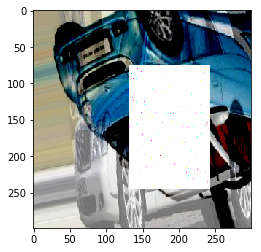

In [61]:
a,b = next(train_gen)
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(a[0])

In [58]:
def train(ismixup, israndombox, iscosine, model_name, min_mixup=70, max_mixup=100, warmup_epoch=10):
    train_gen, validation_gen, test_gen = get_gen(ismixup, israndombox, min_mixup=min_mixup, max_mixup=max_mixup,
                                                 )
    model_path = get_model_path(model_dir, model_name, model_type)
    callbacks = get_callback(patient, model_path, lr, len(X_train), cosine=iscosine,warmup_epoch=warmup_epoch)
    model = get_model(app=model_type, image_size=image_size, opt=optimizers.RMSprop(lr=lr), lr=lr)
    history = model.fit_generator(
        train_gen,
        steps_per_epoch=get_steps(nb_train_sample, batch_size),
        epochs=epoch,
        validation_data=validation_gen,
        validation_steps=get_steps(nb_validation_sample, valid_batch_size),
        verbose=1,
        callbacks=callbacks
    )
    return model, history

In [33]:
list_history = {}
list_model = {}
for mixup in [True,False]:
    for randombox in [True,False]:
        for cosine in [True,False]:
            model_name = 'baseline_{}_{}_{}_{}_{}_{}'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                            'cosine', str(cosine))
            print('>>start training {}'.format(model_name))
            model, history = train(ismixup=mixup, israndombox=randombox, iscosine=cosine, model_name = model_name)
            list_model[model_name] = model
            list_history[model_name] = history

>>start training baseline_mixup_True_randombox_True_cosine_True
>>set mixup
Found 3996 validated image filenames belonging to 196 classes.
Found 3996 validated image filenames belonging to 196 classes.
Found 5994 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.
>>model path to save: ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 1/60
250/250 [==============================] - 130s 520ms/step - loss: 5.4570 - acc: 0.0055 - val_loss: 5.2779 - val_acc: 0.0087

Epoch 00001: val_loss improved from inf to 5.27791, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 2/60
250/250 [==============================] - 125s 501ms/step - loss: 5.3551 - acc: 0.0045 - val_loss: 5.2749 - val_acc: 0.0083

Epoch 00002: val_loss improved from 5.27791 to 5.27485, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 3/60
250/250 [=

Epoch 28/60
250/250 [==============================] - 126s 505ms/step - loss: 3.0119 - acc: 0.4529 - val_loss: 1.9410 - val_acc: 0.5606

Epoch 00028: val_loss improved from 1.96362 to 1.94104, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 29/60
250/250 [==============================] - 126s 505ms/step - loss: 2.9609 - acc: 0.4833 - val_loss: 1.8198 - val_acc: 0.5866

Epoch 00029: val_loss improved from 1.94104 to 1.81979, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 30/60
250/250 [==============================] - 126s 506ms/step - loss: 2.8880 - acc: 0.4919 - val_loss: 1.8054 - val_acc: 0.5868

Epoch 00030: val_loss improved from 1.81979 to 1.80538, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 31/60
250/250 [==============================] - 126s 506ms/step - loss: 2.7990 - acc: 0.5253 - val_loss: 1.7088 - val_acc: 

Epoch 57/60
250/250 [==============================] - 126s 503ms/step - loss: 2.2384 - acc: 0.7352 - val_loss: 1.1853 - val_acc: 0.7236

Epoch 00057: val_loss improved from 1.18660 to 1.18532, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 58/60
250/250 [==============================] - 126s 503ms/step - loss: 2.2508 - acc: 0.7334 - val_loss: 1.1846 - val_acc: 0.7239

Epoch 00058: val_loss improved from 1.18532 to 1.18464, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 59/60
250/250 [==============================] - 126s 505ms/step - loss: 2.2533 - acc: 0.7371 - val_loss: 1.1838 - val_acc: 0.7244

Epoch 00059: val_loss improved from 1.18464 to 1.18378, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_0711_1012_Xception.hdf5
Epoch 60/60
250/250 [==============================] - 126s 505ms/step - loss: 2.2595 - acc: 0.7302 - val_loss: 1.1872 - val_acc: 

250/250 [==============================] - 126s 504ms/step - loss: 1.7240 - acc: 0.9067 - val_loss: 0.8290 - val_acc: 0.8023

Epoch 00056: val_loss did not improve from 0.80267
Epoch 57/60
250/250 [==============================] - 126s 504ms/step - loss: 1.6971 - acc: 0.9034 - val_loss: 0.8134 - val_acc: 0.8045

Epoch 00057: val_loss did not improve from 0.80267

Epoch 00057: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 58/60
250/250 [==============================] - 126s 504ms/step - loss: 1.7048 - acc: 0.9120 - val_loss: 0.8016 - val_acc: 0.8128

Epoch 00058: val_loss improved from 0.80267 to 0.80157, saving model to ../model/baseline_mixup_True_randombox_True_cosine_False_0711_1218_Xception.hdf5
Epoch 59/60
250/250 [==============================] - 126s 504ms/step - loss: 1.6955 - acc: 0.9152 - val_loss: 0.7944 - val_acc: 0.8146

Epoch 00059: val_loss improved from 0.80157 to 0.79436, saving model to ../model/baseline_mixup_True_randombox_True_cosine_F

Epoch 52/60
250/250 [==============================] - 126s 502ms/step - loss: 2.3948 - acc: 0.6917 - val_loss: 1.3407 - val_acc: 0.6904

Epoch 00052: val_loss did not improve from 1.33976
Epoch 53/60
250/250 [==============================] - 126s 503ms/step - loss: 2.4041 - acc: 0.6855 - val_loss: 1.3270 - val_acc: 0.6929

Epoch 00053: val_loss improved from 1.33976 to 1.32703, saving model to ../model/baseline_mixup_True_randombox_False_cosine_True_0711_1425_Xception.hdf5
Epoch 54/60
250/250 [==============================] - 126s 502ms/step - loss: 2.4057 - acc: 0.6904 - val_loss: 1.3295 - val_acc: 0.6944

Epoch 00054: val_loss did not improve from 1.32703
Epoch 55/60
250/250 [==============================] - 126s 502ms/step - loss: 2.3633 - acc: 0.6927 - val_loss: 1.3241 - val_acc: 0.6930

Epoch 00055: val_loss improved from 1.32703 to 1.32409, saving model to ../model/baseline_mixup_True_randombox_False_cosine_True_0711_1425_Xception.hdf5
Epoch 56/60
250/250 [===================

250/250 [==============================] - 126s 504ms/step - loss: 1.8937 - acc: 0.8508 - val_loss: 0.8743 - val_acc: 0.7806

Epoch 00050: val_loss improved from 0.93310 to 0.87429, saving model to ../model/baseline_mixup_True_randombox_False_cosine_False_0711_1631_Xception.hdf5
Epoch 51/60
250/250 [==============================] - 127s 506ms/step - loss: 1.8934 - acc: 0.8547 - val_loss: 0.9046 - val_acc: 0.7798

Epoch 00051: val_loss did not improve from 0.87429
Epoch 52/60
250/250 [==============================] - 127s 507ms/step - loss: 1.8591 - acc: 0.8591 - val_loss: 0.9135 - val_acc: 0.7718

Epoch 00052: val_loss did not improve from 0.87429
Epoch 53/60
250/250 [==============================] - 126s 506ms/step - loss: 1.8400 - acc: 0.8588 - val_loss: 0.9195 - val_acc: 0.7781

Epoch 00053: val_loss did not improve from 0.87429

Epoch 00053: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 54/60
250/250 [==============================] - 126s 505ms/step -

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (3.763329). Check your callbacks.
  % delta_t_median)


250/250 [==============================] - 137s 550ms/step - loss: 5.4574 - acc: 0.0045 - val_loss: 5.1304 - val_acc: 0.0347

Epoch 00001: val_loss improved from inf to 5.13042, saving model to ../model/baseline_mixup_False_randombox_True_cosine_True_0711_1838_Xception.hdf5
Epoch 2/60
250/250 [==============================] - 126s 503ms/step - loss: 5.1812 - acc: 0.0171 - val_loss: 4.8669 - val_acc: 0.0802

Epoch 00002: val_loss improved from 5.13042 to 4.86693, saving model to ../model/baseline_mixup_False_randombox_True_cosine_True_0711_1838_Xception.hdf5
Epoch 3/60
250/250 [==============================] - 126s 504ms/step - loss: 4.8862 - acc: 0.0395 - val_loss: 4.5035 - val_acc: 0.1632

Epoch 00003: val_loss improved from 4.86693 to 4.50354, saving model to ../model/baseline_mixup_False_randombox_True_cosine_True_0711_1838_Xception.hdf5
Epoch 4/60
250/250 [==============================] - 126s 504ms/step - loss: 4.5238 - acc: 0.0855 - val_loss: 4.0339 - val_acc: 0.2514

Epoch 00

250/250 [==============================] - 126s 504ms/step - loss: 0.3714 - acc: 0.9185 - val_loss: 0.6620 - val_acc: 0.8161

Epoch 00030: val_loss improved from 0.66706 to 0.66204, saving model to ../model/baseline_mixup_False_randombox_True_cosine_True_0711_1838_Xception.hdf5
Epoch 31/60
250/250 [==============================] - 126s 504ms/step - loss: 0.3556 - acc: 0.9219 - val_loss: 0.6436 - val_acc: 0.8202

Epoch 00031: val_loss improved from 0.66204 to 0.64358, saving model to ../model/baseline_mixup_False_randombox_True_cosine_True_0711_1838_Xception.hdf5
Epoch 32/60
250/250 [==============================] - 126s 504ms/step - loss: 0.3270 - acc: 0.9252 - val_loss: 0.6439 - val_acc: 0.8188

Epoch 00032: val_loss did not improve from 0.64358
Epoch 33/60
250/250 [==============================] - 126s 504ms/step - loss: 0.3075 - acc: 0.9322 - val_loss: 0.6374 - val_acc: 0.8238

Epoch 00033: val_loss improved from 0.64358 to 0.63744, saving model to ../model/baseline_mixup_False_r

250/250 [==============================] - 132s 527ms/step - loss: 4.8773 - acc: 0.0398 - val_loss: 4.4809 - val_acc: 0.1705

Epoch 00003: val_loss improved from 4.86542 to 4.48086, saving model to ../model/baseline_mixup_False_randombox_True_cosine_False_0711_2044_Xception.hdf5
Epoch 4/60
250/250 [==============================] - 132s 527ms/step - loss: 4.5130 - acc: 0.0875 - val_loss: 4.0206 - val_acc: 0.2523

Epoch 00004: val_loss improved from 4.48086 to 4.02062, saving model to ../model/baseline_mixup_False_randombox_True_cosine_False_0711_2044_Xception.hdf5
Epoch 5/60
250/250 [==============================] - 132s 527ms/step - loss: 4.1371 - acc: 0.1421 - val_loss: 3.5949 - val_acc: 0.2931

Epoch 00005: val_loss improved from 4.02062 to 3.59488, saving model to ../model/baseline_mixup_False_randombox_True_cosine_False_0711_2044_Xception.hdf5
Epoch 6/60
250/250 [==============================] - 132s 526ms/step - loss: 3.7622 - acc: 0.1922 - val_loss: 3.1872 - val_acc: 0.3805

E

250/250 [==============================] - 132s 527ms/step - loss: 0.2904 - acc: 0.9367 - val_loss: 0.6913 - val_acc: 0.8126

Epoch 00033: val_loss did not improve from 0.67220
Epoch 34/60
250/250 [==============================] - 132s 527ms/step - loss: 0.2674 - acc: 0.9337 - val_loss: 0.6357 - val_acc: 0.8227

Epoch 00034: val_loss improved from 0.67220 to 0.63572, saving model to ../model/baseline_mixup_False_randombox_True_cosine_False_0711_2044_Xception.hdf5
Epoch 35/60
250/250 [==============================] - 132s 527ms/step - loss: 0.2600 - acc: 0.9407 - val_loss: 0.6943 - val_acc: 0.8123

Epoch 00035: val_loss did not improve from 0.63572
Epoch 36/60
250/250 [==============================] - 132s 527ms/step - loss: 0.2483 - acc: 0.9400 - val_loss: 0.7209 - val_acc: 0.8068

Epoch 00036: val_loss did not improve from 0.63572
Epoch 37/60
250/250 [==============================] - 132s 527ms/step - loss: 0.2453 - acc: 0.9450 - val_loss: 0.6864 - val_acc: 0.8138

Epoch 00037: va

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (5.587354). Check your callbacks.
  % delta_t_median)


  2/250 [..............................] - ETA: 33:32 - loss: 5.5695 - acc: 0.0000e+00  

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.354258). Check your callbacks.
  % delta_t_median)


250/250 [==============================] - 143s 572ms/step - loss: 5.4445 - acc: 0.0065 - val_loss: 5.1070 - val_acc: 0.0434

Epoch 00001: val_loss improved from inf to 5.10697, saving model to ../model/baseline_mixup_False_randombox_False_cosine_True_0711_2257_Xception.hdf5
Epoch 2/60
250/250 [==============================] - 127s 510ms/step - loss: 5.1274 - acc: 0.0236 - val_loss: 4.7917 - val_acc: 0.1056

Epoch 00002: val_loss improved from 5.10697 to 4.79167, saving model to ../model/baseline_mixup_False_randombox_False_cosine_True_0711_2257_Xception.hdf5
Epoch 3/60
250/250 [==============================] - 127s 510ms/step - loss: 4.7708 - acc: 0.0554 - val_loss: 4.3467 - val_acc: 0.2012

Epoch 00003: val_loss improved from 4.79167 to 4.34666, saving model to ../model/baseline_mixup_False_randombox_False_cosine_True_0711_2257_Xception.hdf5
Epoch 4/60
250/250 [==============================] - 127s 509ms/step - loss: 4.3485 - acc: 0.1217 - val_loss: 3.8346 - val_acc: 0.3055

Epoch


Epoch 00016: val_loss improved from 0.99716 to 0.91776, saving model to ../model/baseline_mixup_False_randombox_False_cosine_False_0712_0038_Xception.hdf5
Epoch 17/60
250/250 [==============================] - 128s 512ms/step - loss: 0.5125 - acc: 0.8803 - val_loss: 0.8633 - val_acc: 0.7681

Epoch 00017: val_loss improved from 0.91776 to 0.86331, saving model to ../model/baseline_mixup_False_randombox_False_cosine_False_0712_0038_Xception.hdf5
Epoch 18/60
250/250 [==============================] - 128s 512ms/step - loss: 0.4475 - acc: 0.9005 - val_loss: 0.8232 - val_acc: 0.7823

Epoch 00018: val_loss improved from 0.86331 to 0.82320, saving model to ../model/baseline_mixup_False_randombox_False_cosine_False_0712_0038_Xception.hdf5
Epoch 19/60
250/250 [==============================] - 128s 511ms/step - loss: 0.3725 - acc: 0.9260 - val_loss: 0.7960 - val_acc: 0.7888

Epoch 00019: val_loss improved from 0.82320 to 0.79603, saving model to ../model/baseline_mixup_False_randombox_False_co

In [73]:
def plot_history(history, model_name):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(model_name)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.ylim(0.0, 1.0)
    plt.grid(color='b', linestyle='-', linewidth=0.1, which='both')
    plt.yticks([x/100 for x in range(0, 100,5)])
    plt.xticks([x for x in range(0, 60,5)])
    plt.show()

dict_keys(['baseline_mixup_False_randombox_True_cosine_True', 'baseline_mixup_False_randombox_False_cosine_False', 'baseline_mixup_False_randombox_False_cosine_True', 'baseline_mixup_False_randombox_True_cosine_False', 'baseline_mixup_True_randombox_True_cosine_False', 'baseline_mixup_True_randombox_False_cosine_False', 'baseline_mixup_True_randombox_True_cosine_True', 'baseline_mixup_True_randombox_False_cosine_True'])


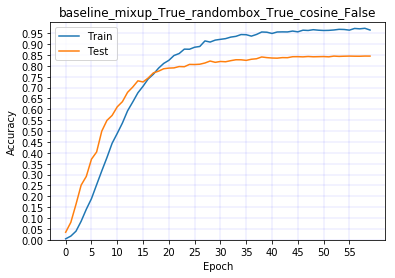

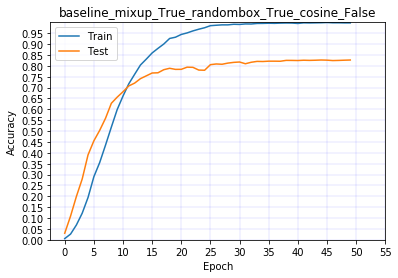

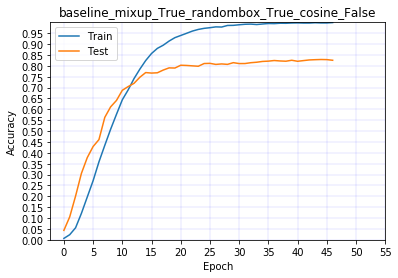

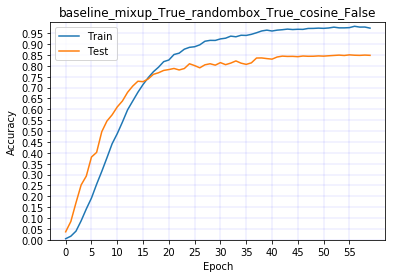

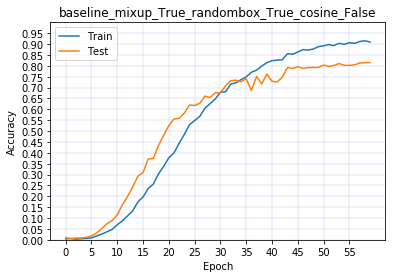

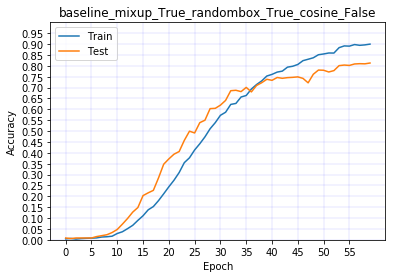

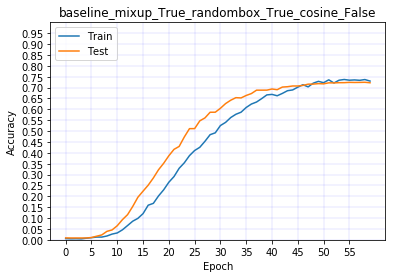

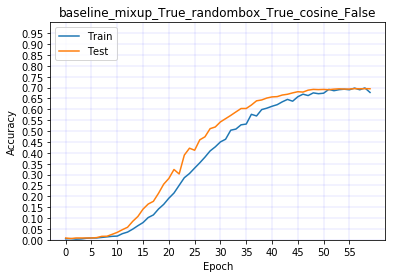

In [74]:
print(list_history.keys())
for key in list(list_history.keys()):
    history = list_history[key]
    plot_history(history, model_name)

val_acc is being smaller then acc at idx >>46


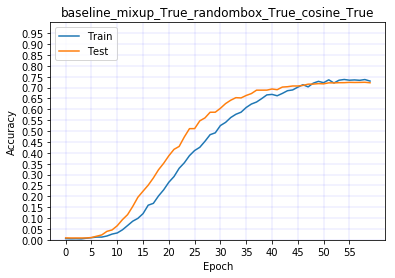

val_acc is being smaller then acc at idx >>34


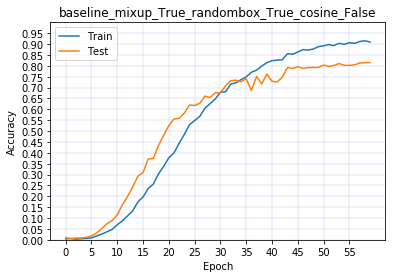

In [81]:
for mixup in [True]:
    for cosine in [True, False]:
        for randombox in [True]:
            model_name = 'baseline_{}_{}_{}_{}_{}_{}'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                    'cosine', str(cosine))
            history = list_history[model_name]
            for idx in range(len(history.history['val_acc'])):
                if history.history['acc'][idx] > history.history['val_acc'][idx]:
                    if idx>30:
                        print('val_acc is being smaller then acc at idx >>{}'.format(idx))
                        plot_history(history, model_name)
                        break
  #cosine decay 는 무조건 하자!!

val_acc is being smaller then acc at idx >>46


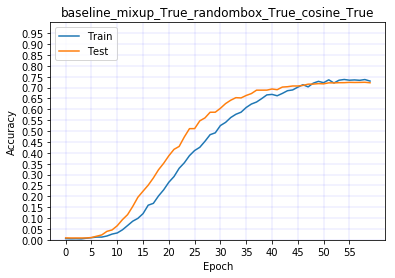

val_acc is being smaller then acc at idx >>31


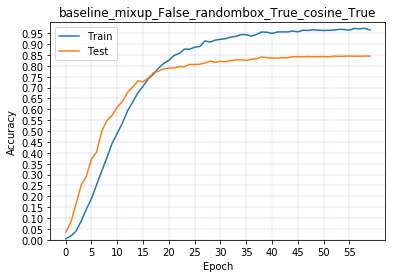

In [82]:
for mixup in [True, False]:
    for cosine in [True]:
        for randombox in [True]:
            model_name = 'baseline_{}_{}_{}_{}_{}_{}'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                    'cosine', str(cosine))
            history = list_history[model_name]
            for idx in range(len(history.history['val_acc'])):
                if history.history['acc'][idx] > history.history['val_acc'][idx]:
                    if idx>30:
                        print('val_acc is being smaller then acc at idx >>{}'.format(idx))
                        plot_history(history, model_name)
                        break
  #mixup도 하자!! 는 무조건 하자!!

val_acc is being smaller then acc at idx >>46


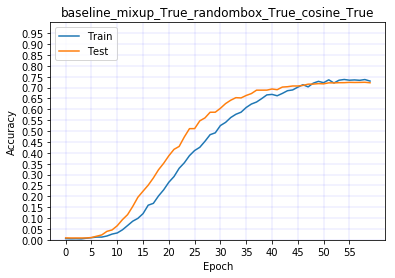

val_acc is being smaller then acc at idx >>51


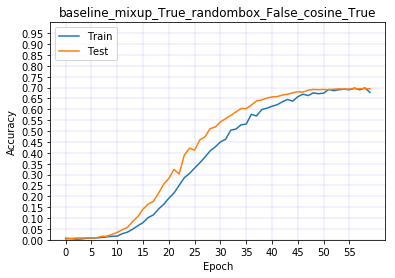

In [83]:
for mixup in [True]:
    for cosine in [True]:
        for randombox in [True, False]:
            model_name = 'baseline_{}_{}_{}_{}_{}_{}'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                    'cosine', str(cosine))
            history = list_history[model_name]
            for idx in range(len(history.history['val_acc'])):
                if history.history['acc'][idx] > history.history['val_acc'][idx]:
                    if idx>30:
                        print('val_acc is being smaller then acc at idx >>{}'.format(idx))
                        plot_history(history, model_name)
                        break
 #randombox는 좀 더 테스트 해보자!!

In [87]:
model_type='Xception'
image_size = 299 if model_type=='Xception' else 224
split_size = 0.7
patient = 10
lr = 0.0001
epoch=100
K.clear_session()

In [88]:
TRAIN_CROP_PATH = os.path.join(DATA_PATH, 'train_crop_{}'.format(image_size))
TEST_CROP_PATH = os.path.join(DATA_PATH, 'test_crop_{}'.format(image_size))
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_train["class"] = df_train["class"].astype('str')
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]
X_train, X_val = split_traindf(df_train.iloc[:, :], train_size=split_size, stratify=True)
nb_train_sample = X_train.shape[0]
nb_validation_sample = X_val.shape[0]
nb_test_sample = df_test.shape[0]

In [89]:
erasor_history = {}
erasor_model = {}
for mixup in [True]:
    for randombox in [True,False]:
        for cosine in [True]:
            model_name = 'baseline_{}_{}_{}_{}_{}_{}_erasortest'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                            'cosine', str(cosine))
            print('>>start training {}'.format(model_name))
            model, history = train(ismixup=mixup, israndombox=randombox, iscosine=cosine, model_name = model_name)
            erasor_model[model_name] = model
            erasor_history[model_name] = history

>>start training baseline_mixup_True_randombox_True_cosine_True_erasortest
>>set mixup
Found 6993 validated image filenames belonging to 196 classes.
Found 6993 validated image filenames belonging to 196 classes.
Found 2997 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.
>>model path to save: ../model/baseline_mixup_True_randombox_True_cosine_True_erasortest_0712_0305_Xception.hdf5
Epoch 1/100
438/438 [==============================] - 189s 432ms/step - loss: 5.4089 - acc: 0.0043 - val_loss: 5.2784 - val_acc: 0.0083

Epoch 00001: val_loss improved from inf to 5.27843, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_erasortest_0712_0305_Xception.hdf5
Epoch 2/100
438/438 [==============================] - 183s 417ms/step - loss: 5.3104 - acc: 0.0043 - val_loss: 5.2708 - val_acc: 0.0083

Epoch 00002: val_loss improved from 5.27843 to 5.27080, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_erasortest

Epoch 28/100
438/438 [==============================] - 183s 418ms/step - loss: 2.0230 - acc: 0.7897 - val_loss: 0.6881 - val_acc: 0.8282

Epoch 00028: val_loss did not improve from 0.67000
Epoch 29/100
438/438 [==============================] - 182s 417ms/step - loss: 1.9673 - acc: 0.8134 - val_loss: 0.6807 - val_acc: 0.8272

Epoch 00029: val_loss did not improve from 0.67000
Epoch 30/100
438/438 [==============================] - 183s 417ms/step - loss: 1.9577 - acc: 0.8105 - val_loss: 0.6185 - val_acc: 0.8519

Epoch 00030: val_loss improved from 0.67000 to 0.61853, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_erasortest_0712_0305_Xception.hdf5
Epoch 31/100
438/438 [==============================] - 182s 416ms/step - loss: 1.9130 - acc: 0.8283 - val_loss: 0.6004 - val_acc: 0.8458

Epoch 00031: val_loss improved from 0.61853 to 0.60036, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_erasortest_0712_0305_Xception.hdf5
Epoch 32/100
438

438/438 [==============================] - 182s 415ms/step - loss: 5.2792 - acc: 0.0077 - val_loss: 5.2629 - val_acc: 0.0083

Epoch 00006: val_loss improved from 5.27117 to 5.26290, saving model to ../model/baseline_mixup_True_randombox_False_cosine_True_erasortest_0712_0742_Xception.hdf5
Epoch 7/100
438/438 [==============================] - 182s 415ms/step - loss: 5.2687 - acc: 0.0083 - val_loss: 5.2216 - val_acc: 0.0083

Epoch 00007: val_loss improved from 5.26290 to 5.22163, saving model to ../model/baseline_mixup_True_randombox_False_cosine_True_erasortest_0712_0742_Xception.hdf5
Epoch 8/100
438/438 [==============================] - 182s 415ms/step - loss: 5.2379 - acc: 0.0100 - val_loss: 5.1728 - val_acc: 0.0137

Epoch 00008: val_loss improved from 5.22163 to 5.17285, saving model to ../model/baseline_mixup_True_randombox_False_cosine_True_erasortest_0712_0742_Xception.hdf5
Epoch 9/100
438/438 [==============================] - 182s 416ms/step - loss: 5.1874 - acc: 0.0140 - val_

Epoch 34/100
438/438 [==============================] - 183s 417ms/step - loss: 2.5602 - acc: 0.6271 - val_loss: 1.2799 - val_acc: 0.6880

Epoch 00034: val_loss did not improve from 1.21191
Epoch 35/100
438/438 [==============================] - 183s 417ms/step - loss: 2.4858 - acc: 0.6485 - val_loss: 1.0704 - val_acc: 0.7528

Epoch 00035: val_loss improved from 1.21191 to 1.07043, saving model to ../model/baseline_mixup_True_randombox_False_cosine_True_erasortest_0712_0742_Xception.hdf5
Epoch 36/100
438/438 [==============================] - 183s 417ms/step - loss: 2.4205 - acc: 0.6668 - val_loss: 1.0987 - val_acc: 0.7401

Epoch 00036: val_loss did not improve from 1.07043
Epoch 37/100
438/438 [==============================] - 183s 417ms/step - loss: 2.3573 - acc: 0.6869 - val_loss: 0.9810 - val_acc: 0.7628

Epoch 00037: val_loss improved from 1.07043 to 0.98096, saving model to ../model/baseline_mixup_True_randombox_False_cosine_True_erasortest_0712_0742_Xception.hdf5
Epoch 38/100
4

val_acc is being smaller then acc at idx >>31


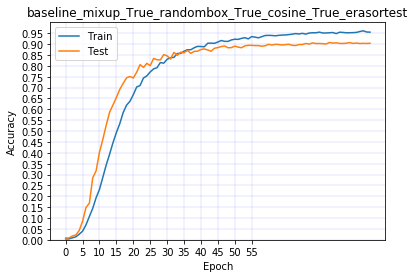

val_acc is being smaller then acc at idx >>52


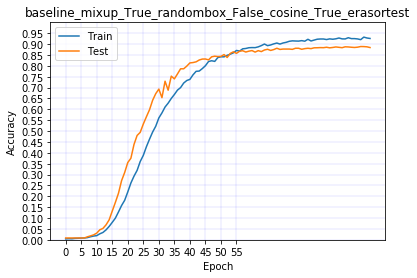

In [90]:
for mixup in [True]:
    for cosine in [True]:
        for randombox in [True, False]:
            model_name = 'baseline_{}_{}_{}_{}_{}_{}_erasortest'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                    'cosine', str(cosine))
            history = erasor_history[model_name]
            for idx in range(len(history.history['val_acc'])):
                if history.history['acc'][idx] > history.history['val_acc'][idx]:
                    if idx>30:
                        print('val_acc is being smaller then acc at idx >>{}'.format(idx))
                        plot_history(history, model_name)
                        break
 #randombox는 좀 더 테스트 해보자!!

In [108]:
split_size = 0.75
patient = 15
epoch=120
X_train, X_val = split_traindf(df_train.iloc[:, :], train_size=split_size, stratify=True)
nb_train_sample = X_train.shape[0]
nb_validation_sample = X_val.shape[0]
nb_test_sample = df_test.shape[0]
erasor_history = {}
mixup_range_model = []
for mixup in [True]:
    for randombox in [True]:
        for cosine in [True]:
            for min_mixup, max_mixup in zip([60,70], [90, 95]):
                model_name = 'baseline_{}_{}_{}_{}_{}_{}_mixup_range({}_{})'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                'cosine', str(cosine), min_mixup, max_mixup)
                print('>>start training {}'.format(model_name))
                model, history = train(ismixup=mixup, israndombox=randombox, iscosine=cosine, model_name = model_name, min_mixup=min_mixup,
                               max_mixup=max_mixup)
                mixup_range_model[model_name] = model
                erasor_history[model_name] = history

>>start training baseline_mixup_True_randombox_True_cosine_True_mixup_range(60_90)
>>set mixup
Found 7492 validated image filenames belonging to 196 classes.
Found 7492 validated image filenames belonging to 196 classes.
Found 2498 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.
>>model path to save: ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(60_90)_0712_1337_Xception.hdf5
Epoch 1/120
469/469 [==============================] - 199s 425ms/step - loss: 5.3962 - acc: 0.0053 - val_loss: 5.2811 - val_acc: 0.0084

Epoch 00001: val_loss improved from inf to 5.28110, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(60_90)_0712_1337_Xception.hdf5
Epoch 2/120
469/469 [==============================] - 192s 409ms/step - loss: 5.3056 - acc: 0.0052 - val_loss: 5.2738 - val_acc: 0.0084

Epoch 00002: val_loss improved from 5.28110 to 5.27378, saving model to ../model/baseline_mixup_True_randombox_Tru

469/469 [==============================] - 193s 412ms/step - loss: 2.9599 - acc: 0.6139 - val_loss: 1.0447 - val_acc: 0.7674

Epoch 00026: val_loss improved from 1.09609 to 1.04466, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(60_90)_0712_1337_Xception.hdf5
Epoch 27/120
469/469 [==============================] - 193s 412ms/step - loss: 2.9009 - acc: 0.6337 - val_loss: 0.9589 - val_acc: 0.7746

Epoch 00027: val_loss improved from 1.04466 to 0.95886, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(60_90)_0712_1337_Xception.hdf5
Epoch 28/120
469/469 [==============================] - 193s 411ms/step - loss: 2.8338 - acc: 0.6612 - val_loss: 0.9162 - val_acc: 0.7774

Epoch 00028: val_loss improved from 0.95886 to 0.91622, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(60_90)_0712_1337_Xception.hdf5
Epoch 29/120
469/469 [==============================] - 193s 411ms/step - loss: 2.8

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (3.164090). Check your callbacks.
  % delta_t_median)


469/469 [==============================] - 203s 434ms/step - loss: 5.4022 - acc: 0.0056 - val_loss: 5.2788 - val_acc: 0.0084

Epoch 00001: val_loss improved from inf to 5.27880, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(70_95)_0712_1808_Xception.hdf5
Epoch 2/120
469/469 [==============================] - 193s 412ms/step - loss: 5.3077 - acc: 0.0057 - val_loss: 5.2713 - val_acc: 0.0084

Epoch 00002: val_loss improved from 5.27880 to 5.27131, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(70_95)_0712_1808_Xception.hdf5
Epoch 3/120
469/469 [==============================] - 192s 410ms/step - loss: 5.2777 - acc: 0.0104 - val_loss: 5.2070 - val_acc: 0.0140

Epoch 00003: val_loss improved from 5.27131 to 5.20697, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_mixup_range(70_95)_0712_1808_Xception.hdf5
Epoch 4/120
469/469 [==============================] - 192s 410ms/step - loss: 5.2157 - a

469/469 [==============================] - 194s 413ms/step - loss: 1.7056 - acc: 0.9371 - val_loss: 0.4641 - val_acc: 0.8927

Epoch 00064: val_loss did not improve from 0.45597
Epoch 65/120
469/469 [==============================] - 194s 413ms/step - loss: 1.7095 - acc: 0.9404 - val_loss: 0.4642 - val_acc: 0.8999

Epoch 00065: val_loss did not improve from 0.45597
Epoch 66/120
469/469 [==============================] - 194s 413ms/step - loss: 1.7089 - acc: 0.9432 - val_loss: 0.4646 - val_acc: 0.9019

Epoch 00066: val_loss did not improve from 0.45597
Epoch 67/120
469/469 [==============================] - 193s 411ms/step - loss: 1.6986 - acc: 0.9403 - val_loss: 0.4706 - val_acc: 0.8975

Epoch 00067: val_loss did not improve from 0.45597
Epoch 68/120
469/469 [==============================] - 193s 411ms/step - loss: 1.7049 - acc: 0.9398 - val_loss: 0.4740 - val_acc: 0.8975

Epoch 00068: val_loss did not improve from 0.45597
Epoch 69/120
469/469 [==============================] - 193s 41

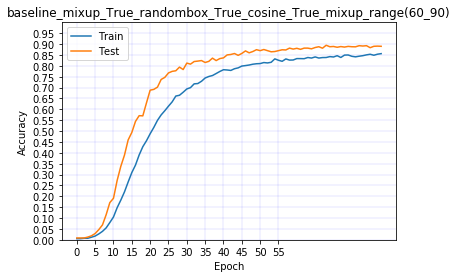

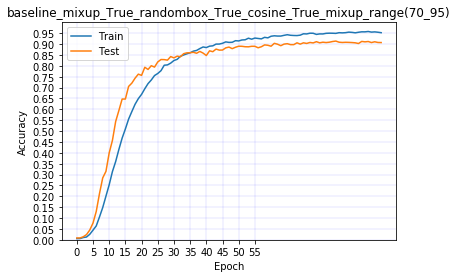

val_acc is being smaller then acc at idx >>32


In [111]:
for mixup in [True]:
    for cosine in [True]:
        for randombox in [True]:
            for min_mixup, max_mixup in zip([60,70], [90, 95]):
                model_name = 'baseline_{}_{}_{}_{}_{}_{}_mixup_range({}_{})'.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                'cosine', str(cosine), min_mixup, max_mixup)
                history = erasor_history[model_name]
                plot_history(history, model_name)
                for idx in range(len(history.history['val_acc'])):
                    if history.history['acc'][idx] > history.history['val_acc'][idx]:
                        if idx>30:
                            print('val_acc is being smaller then acc at idx >>{}'.format(idx))
                            
                            break
     #randombox는 좀 더 테스트 해보자!!

In [114]:
decay__history = {}
model_name_format = 'baseline_{}_{}_{}_{}_{}_{}_({}_{})_nodecay'

split_size = 0.75
patient = 15
epoch=120
X_train, X_val = split_traindf(df_train.iloc[:, :], train_size=split_size, stratify=True)
nb_train_sample = X_train.shape[0]
nb_validation_sample = X_val.shape[0]
nb_test_sample = df_test.shape[0]

K.clear_session()
model_no_cosine = {}
for mixup in [True]:
    for randombox in [True]:
        for cosine in [False]:
            for min_mixup, max_mixup in zip([70], [95]):
                model_name = model_name_format.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                'cosine', str(cosine), min_mixup, max_mixup)
                print('>>start training {}'.format(model_name))
                model, history = train(ismixup=mixup, israndombox=randombox, iscosine=cosine, model_name = model_name, min_mixup=min_mixup,
                               max_mixup=max_mixup)
                model_no_cosine[model_name] = model
                decay__history[model_name] = history

>>start training baseline_mixup_True_randombox_True_cosine_False_(70_95)_nodecay
>>set mixup
Found 7492 validated image filenames belonging to 196 classes.
Found 7492 validated image filenames belonging to 196 classes.
Found 2498 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.
>>model path to save: ../model/baseline_mixup_True_randombox_True_cosine_False_(70_95)_nodecay_0712_2338_Xception.hdf5
Epoch 1/120
469/469 [==============================] - 201s 429ms/step - loss: 5.4117 - acc: 0.0037 - val_loss: 5.2823 - val_acc: 0.0084

Epoch 00001: val_loss improved from inf to 5.28232, saving model to ../model/baseline_mixup_True_randombox_True_cosine_False_(70_95)_nodecay_0712_2338_Xception.hdf5
Epoch 2/120
469/469 [==============================] - 194s 413ms/step - loss: 5.3083 - acc: 0.0061 - val_loss: 5.2743 - val_acc: 0.0084

Epoch 00002: val_loss improved from 5.28232 to 5.27434, saving model to ../model/baseline_mixup_True_randombox_True_cosi


Epoch 00053: val_loss did not improve from 0.66138
Epoch 54/120
469/469 [==============================] - 193s 412ms/step - loss: 2.1194 - acc: 0.8350 - val_loss: 0.6686 - val_acc: 0.8399

Epoch 00054: val_loss did not improve from 0.66138
Epoch 55/120
469/469 [==============================] - 193s 412ms/step - loss: 2.1109 - acc: 0.8465 - val_loss: 0.7327 - val_acc: 0.8175

Epoch 00055: val_loss did not improve from 0.66138

Epoch 00055: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 56/120
469/469 [==============================] - 194s 414ms/step - loss: 2.0640 - acc: 0.8617 - val_loss: 0.5817 - val_acc: 0.8579

Epoch 00056: val_loss improved from 0.66138 to 0.58174, saving model to ../model/baseline_mixup_True_randombox_True_cosine_False_(70_95)_nodecay_0712_2338_Xception.hdf5
Epoch 57/120
469/469 [==============================] - 193s 412ms/step - loss: 2.0263 - acc: 0.8669 - val_loss: 0.5787 - val_acc: 0.8663

Epoch 00057: val_loss improved from 0.58

Epoch 87/120
469/469 [==============================] - 195s 415ms/step - loss: 1.8545 - acc: 0.9336 - val_loss: 0.4886 - val_acc: 0.8891

Epoch 00087: val_loss did not improve from 0.48142
Epoch 88/120
469/469 [==============================] - 194s 415ms/step - loss: 1.8367 - acc: 0.9340 - val_loss: 0.4835 - val_acc: 0.8899

Epoch 00088: val_loss did not improve from 0.48142
Epoch 89/120
469/469 [==============================] - 194s 413ms/step - loss: 1.8310 - acc: 0.9383 - val_loss: 0.5003 - val_acc: 0.8863

Epoch 00089: val_loss did not improve from 0.48142
Epoch 90/120
469/469 [==============================] - 194s 414ms/step - loss: 1.8326 - acc: 0.9370 - val_loss: 0.4862 - val_acc: 0.8915

Epoch 00090: val_loss did not improve from 0.48142

Epoch 00090: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 91/120
469/469 [==============================] - 194s 415ms/step - loss: 1.8248 - acc: 0.9352 - val_loss: 0.4812 - val_acc: 0.8923

Epoch 00091: val_loss improved from 

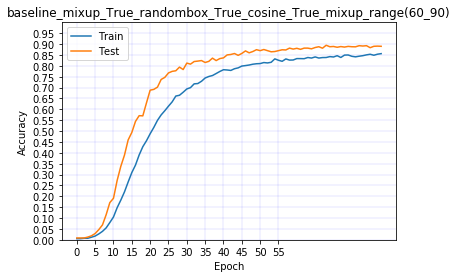

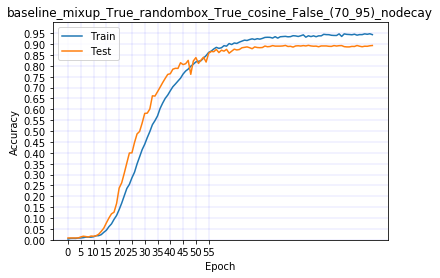

val_acc is being smaller then acc at idx >>48


In [122]:
model_name1 = 'baseline_mixup_True_randombox_True_cosine_True_mixup_range(60_90)'
model_name2 = 'baseline_mixup_True_randombox_True_cosine_False_(70_95)_nodecay'
for model_name , history in zip([model_name1, model_name2], [erasor_history, decay__history]):
    history = history[model_name]
    plot_history(history, model_name)
    for idx in range(len(history.history['val_acc'])):
        if history.history['acc'][idx] > history.history['val_acc'][idx]:
            if idx>30:
                print('val_acc is being smaller then acc at idx >>{}'.format(idx))

                break
     #randombox는 좀 더 테스트 해보자!!

In [130]:
decay__history = {}
model_name_format = 'baseline_{}_{}_{}_{}_{}_{}_({}_{})_warmpup_15'

split_size = 0.75
patient = 15
epoch=150
X_train, X_val = split_traindf(df_train.iloc[:, :], train_size=split_size, stratify=True)
nb_train_sample = X_train.shape[0]
nb_validation_sample = X_val.shape[0]
nb_test_sample = df_test.shape[0]

K.clear_session()
model_fix_mixuprange = {}
for mixup in [True]:
    for randombox in [True]:
        for cosine in [True]:
            for min_mixup, max_mixup in zip([80], [95]):
                model_name = model_name_format.format('mixup', str(mixup), 'randombox', str(randombox),
                                                                'cosine', str(cosine), min_mixup, max_mixup)
                print('>>start training {}'.format(model_name))
                model, history = train(ismixup=mixup, israndombox=randombox, iscosine=cosine, model_name = model_name, min_mixup=min_mixup,
                               max_mixup=max_mixup, warmup_epoch=15)
                model_fix_mixprange[model_name] = model
                decay__history[model_name] = history

>>start training baseline_mixup_True_randombox_True_cosine_True_(80_95)_warmpup_15
>>set mixup
Found 7492 validated image filenames belonging to 196 classes.
Found 7492 validated image filenames belonging to 196 classes.
Found 2498 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.
>>model path to save: ../model/baseline_mixup_True_randombox_True_cosine_True_(80_95)_warmpup_15_0713_0656_Xception.hdf5
Epoch 1/150
469/469 [==============================] - 193s 411ms/step - loss: 5.4175 - acc: 0.0039 - val_loss: 5.2688 - val_acc: 0.0084

Epoch 00001: val_loss improved from inf to 5.26880, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_(80_95)_warmpup_15_0713_0656_Xception.hdf5
Epoch 2/150
469/469 [==============================] - 192s 410ms/step - loss: 5.2735 - acc: 0.0113 - val_loss: 5.0430 - val_acc: 0.0248

Epoch 00002: val_loss improved from 5.26880 to 5.04297, saving model to ../model/baseline_mixup_True_randombox_Tru


Epoch 00028: val_loss did not improve from 0.55452
Epoch 29/150
469/469 [==============================] - 192s 410ms/step - loss: 1.6491 - acc: 0.8678 - val_loss: 0.5649 - val_acc: 0.8619

Epoch 00029: val_loss did not improve from 0.55452
Epoch 30/150
469/469 [==============================] - 193s 412ms/step - loss: 1.6110 - acc: 0.8801 - val_loss: 0.5934 - val_acc: 0.8543

Epoch 00030: val_loss did not improve from 0.55452
Epoch 31/150
469/469 [==============================] - 194s 413ms/step - loss: 1.5944 - acc: 0.8917 - val_loss: 0.5312 - val_acc: 0.8719

Epoch 00031: val_loss improved from 0.55452 to 0.53115, saving model to ../model/baseline_mixup_True_randombox_True_cosine_True_(80_95)_warmpup_15_0713_0656_Xception.hdf5
Epoch 32/150
469/469 [==============================] - 193s 411ms/step - loss: 1.5753 - acc: 0.8918 - val_loss: 0.5474 - val_acc: 0.8699

Epoch 00032: val_loss did not improve from 0.53115
Epoch 33/150
469/469 [==============================] - 193s 412ms/s

469/469 [==============================] - 193s 412ms/step - loss: 1.2314 - acc: 0.9781 - val_loss: 0.4051 - val_acc: 0.9127

Epoch 00106: val_loss did not improve from 0.39584
Epoch 00106: early stopping
